In [1]:
import os
from pySMOKEPostProcessor import KineticMap
from pySMOKEPostProcessor import PostProcessor
from pySMOKEPostProcessor import FluxByClass
from pySMOKEPostProcessor import FDI, assignclass, merge_maps_byspecies
from pySMOKEPostProcessor import plot_heatmap
from pySMOKEPostProcessor import script_utils

# Rate Of Production Analysis by Reaction Class
The rate of production analysis can be organized according to reaction classes. Different levels of classification are available:

> * `Class type`: defined by the user in **rxn_class_groups.txt** text file (see data/Classes). Broad classification (e.g., bond-fission, H-abstraction, growth)
> * `Reaction type`: reaction channels belonging to a certain class type. These are listed within the class types in the text file. They must also be present in the **kinetics.xml** file (hard coded)
> * `Species type`: type of species that defines the functional group participating to the reaction (e.g., A1-M is the aromatic ring in its molecular form, A1-R is a phenyl-like radical)
> * `Bimolecular type`: classification according to unimolecular/bimolecular reaction type, accounting for the nature of the reacting species (M, R, RSR: molecule, radical, resonance-stabilized radical). This classification does not require specific input.

Required input for the different steps

* `FluxByClass`: class that handles the classification of reactions. Input arguments are:
    > * `kin_xml_fld` (*str*): path to the folder containing the files relative to the kinetic mechanism named directly, after the pre-processing by OpenSMOKE++: **kinetics.xml** and **reaction_names.xml**.
    > * `class_groups` (*str*): path to file **rxn_class_groups.txt** (or other name) with the groups.
    
* `FluxByClass.process_flux`: assigns the reaction flux according to the user requests. for now, only global flux analysis is available. This function calls the pySMOKEpostprocessor.RateOfProductionAnalysis. Input arguments are:
    > * `species_list` (*list*): list of species to perform ROPA for; accepts strings or dictionaries if you want to sum up fluxes for more than one species. Example {'PAH': ['C10H8', 'INDENE' ,'BIPHENYL']} sums the flux of these 3 species and names it "PAH" in the heatmap
    > * `simul_fld` (*str*): path to the folder containing OpenSMOKE++ output simulation files. **Output.xml** is required.
    > * `ropa_type` (*str*): type of ROPA (global is the only available option for now).
    > * `n_of_rxns` (*int*, default: 100): number of reactions to be included in the flux analysis (from those with the highest flux).
    

* `FluxByClass.sort_and_filter`: organizes classes for each species flux by reaction class and sums fluxes in the same class. filters classes (i.e., reduces the set of reactions considered) by user-defined criteria. requires:
    > * `sortlist` (*list(str)*): criteria to be considered hierarchically for reaction flux sorting. allowed strings: **classtype,speciestype,reactiontype,bimoltype**. For instance, ['speciestype','reactiontype'] groups reactions according to species type, and within that set the reactions are grouped according to reaction type.
    > * `filter_dct` (*dict: list(str)*, default: {}):filtering for set of classes. dictionary keys correspond to criteria allowed for sortlist, and the value is a list of strings that have to be contained in the class filtered. For instance, {'classtype':['ADD','ABS']} filters all reactions whose classtype includes either 'ADD' or 'ABS' (i.e., abstractions and addition reactions).
    > * `threshold` (*float*, default: 1e-3): minimum relative flux to be considered in the classification. Reactions with smaller flux will be removed.
    > * `weigheach` (*bool*, default: True): weigh the flux of each species according to the maximum absolute flux.

* `plot_heatmap`: plots heat maps according to the dataframe provided
    > * `sortdf` (*pandas dataframe*): flux according to species (column) and reaction class (row)
    > * `symmetricaxis` (*bool*, default: False): decide how to scale the colorbar for plotting. True: 0 is in the middle, and the axis is symmetric with respect to minimum and maximum values. False: axis shifted according to where the 0 is.

In [2]:
kin_xml_fld = os.path.join('..', 'data', 'Classes', 'kinetics')
class_groups_file = os.path.join('..', 'data', 'Classes', 'rxn_class_groups.txt')

sim_flds_toFDI = {'1100': os.path.join('..', 'data', 'Classes', 'simul', 'Output'),
                  '1300': os.path.join('..', 'data', 'Classes', 'simul2', 'Output'),
                  '1500': os.path.join('..', 'data', 'Classes', 'simul3', 'Output')}


In [3]:
# sort the reactions - same for all examples
rxns_sorted = script_utils.get_sortedrxns(kin_xml_fld, class_groups_file)

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes_utilities/reaction_classes_calc.py:141: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.rxn_class_df['name'][idx] = rxn['name

### Example 5 - comparison by FDI
calculate flux analysis for multiple simulations, group by class, and build distance triangular matrices to compare. for full methodology, see 10.1016/J.COMBUSTFLAME.2022.112073
Available comparisons: global, by one species (all classes), by one class (all species)

In [4]:
# FDI
# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']},
               {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria

threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'omegaij' #to get the FDI

# do not edit
omegadf_dct = dict.fromkeys(sim_flds_toFDI.keys())
for simname, simfld in sim_flds_toFDI.items():
    sortdfs = script_utils.process_classes(simfld, kin_xml_fld, rxns_sorted, species_list, sortlists, ropa_type,
                                           n_of_rxns=n_of_rxns, threshs=threshs, mass_ropa=mass_ropa, weigh=weigh)
    omegadf_dct[simname] = sortdfs[0]


/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes_utilities/reaction_classes_calc.py:374: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_omegaijn[cl][sp] = val/omegamin
/opt/ho

In [5]:
df_FDI_final = FDI(omegadf_dct, fditype='global',)
print(df_FDI_final)

      1100      1300      1500
1500   0.0  0.000000  0.000000
1300   0.0  0.000000 -0.303352
1100   0.0  0.145185  0.158166


/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:238: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_FDI[m][n] = np.power(np.sum(df_diff_square.values), 0.5)
/opt/homebrew/

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:238: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_FDI[m][n] = np.power(np.sum(df_diff_square.values), 0.5)
/opt/homebrew/

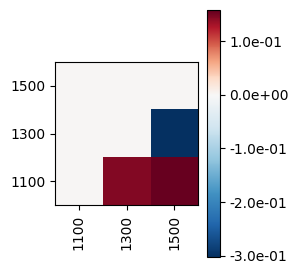

In [6]:
# global
df_FDI_final = FDI(omegadf_dct, fditype='global',)
fig = plot_heatmap(df_FDI_final, symmetricaxis = False, dftype = 'generic')

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:241: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_FDI[m][n] = np.power(
/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib

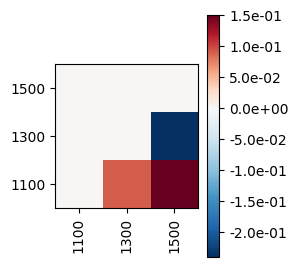

In [7]:
# by species
df_FDI_final = FDI(omegadf_dct, fditype='species', speciesi='A1')
fig = plot_heatmap(df_FDI_final, symmetricaxis=False, dftype='generic')

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:245: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_FDI[m][n] = np.power(
/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib

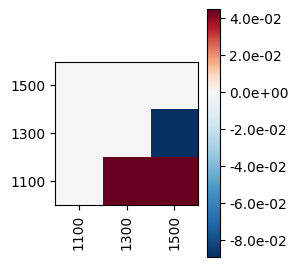

In [8]:
df_FDI_final = FDI(omegadf_dct, fditype='class', classj='DECOMPOSITION')
fig = plot_heatmap(df_FDI_final, symmetricaxis=False, dftype='generic')

## Example 6: compare multiple simulations for sets of species
consider sets of simulations and produce synthetic heat maps
Recommended: use normalized flux for easier relative comparisons

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dftot = pd.concat([dftot, pdnew])
/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dftot = pd.concat([dftot, pdnew])
/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/re

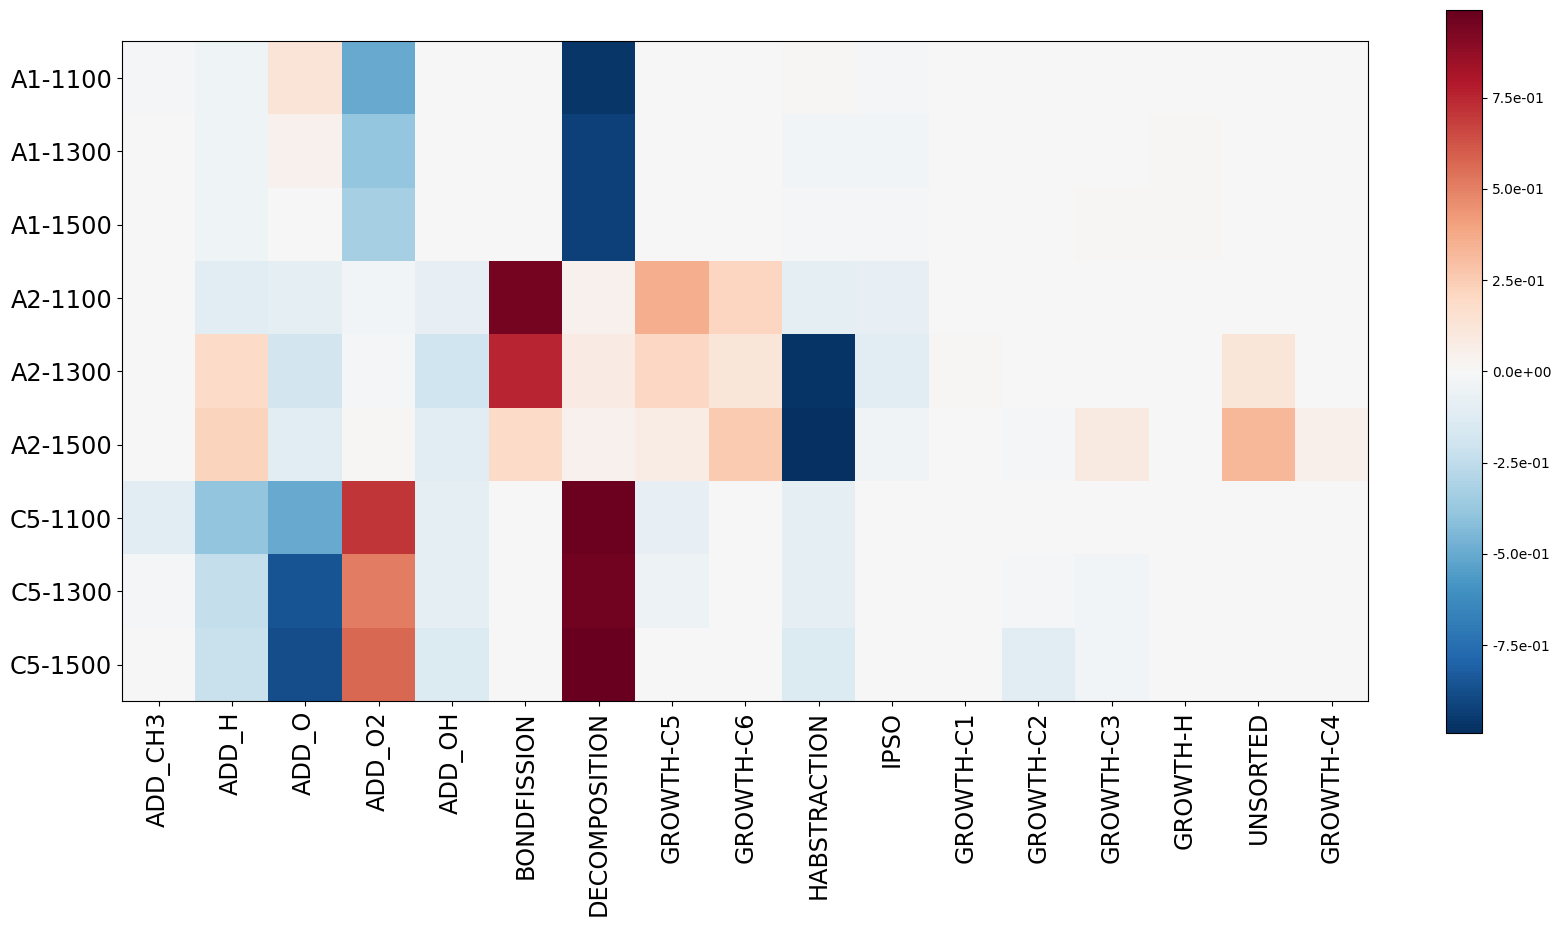

In [9]:
# merge maps of multiple simulations according to the type of species

# species and sorting options
species_list =[{'A1':['C6H6', 'C6H5', 'C6H5OH', 'C6H5O']},
               {'C5': ['C5H6', 'C5H5', 'C5H6OH', 'C5H5O', 'C5H4O']},
               {'A2': ['C10H8', 'INDENE', 'BIPHENYL', 'C12H8']}]
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria

threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = False

# do not edit
all_dct = dict.fromkeys(sim_flds_toFDI.keys())
for simname, simfld in sim_flds_toFDI.items():
    sortdfs = script_utils.process_classes(simfld, kin_xml_fld, rxns_sorted, species_list, sortlists,
                                           ropa_type, n_of_rxns=n_of_rxns, threshs=threshs, mass_ropa=mass_ropa)
    all_dct[simname] = sortdfs[0]

merged_dct = merge_maps_byspecies(all_dct)
fig = plot_heatmap(merged_dct, symmetricaxis = True, dftype = 'flux')

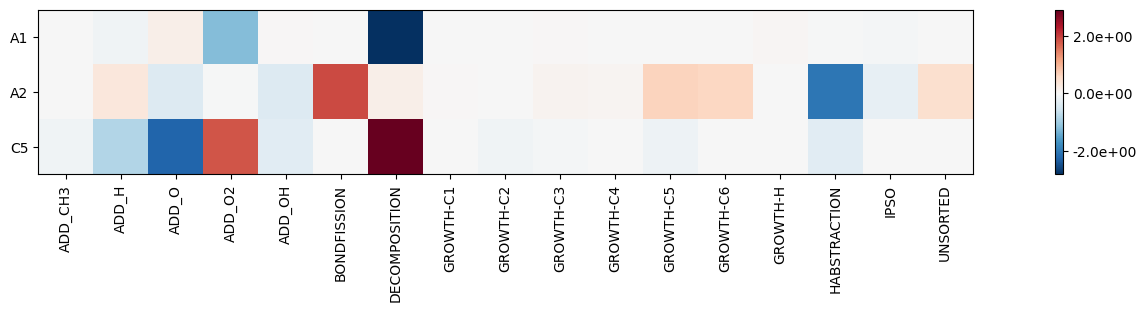

In [10]:
# sum the fluxes instead of comparing them
merged_dct = merge_maps_byspecies(all_dct, tosum=True)
fig = plot_heatmap(merged_dct, symmetricaxis=False, dftype='flux')

In [11]:
kin_xml_fld_soot = os.path.join('..', 'data', 'Classes', 'kinetics-soot')
class_groups_fld_soot = os.path.join('..', 'data', 'Classes', 'rxn_class_groups-soot.txt')

sim_flds_toFDI_soot = {'PMLOWFV': os.path.join('..', 'data', 'Classes', 'F14'),
                       'PMHIGHFV': os.path.join('..', 'data', 'Classes', 'F26'),
                       'CFLOWFV': os.path.join('..', 'data', 'Classes', 'F48',),
                       'CFHIGHFV': os.path.join('..', 'data', 'Classes', 'F61',),}

# sort the reactions - same for all examples
rxns_sorted_soot = script_utils.get_sortedrxns(kin_xml_fld_soot, class_groups_fld_soot)

/opt/homebrew/Caskroom/miniconda/base/envs/pp/lib/python3.12/site-packages/pySMOKEPostProcessor/reaction_classes_utilities/reaction_classes_calc.py:141: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.rxn_class_df['name'][idx] = rxn['name

In [12]:
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria
#filter_dcts = [{'classtype':['INCEPTION', 'HACA','GROWTH', 'OXIDATION']}]
filter_dcts = [{}]
threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'false' 

species_list =['BIN5AJ','BIN5BJ','BIN5CJ',
               'BIN4AJ','BIN4BJ','BIN4CJ',
               'BIN3AJ','BIN3BJ','BIN3CJ',
               'BIN3A','BIN3B','BIN3C',
               'BIN1AJ','BIN1BJ','BIN1CJ',
               'BIN1A','BIN1B','BIN1C']

simfld = sim_flds_toFDI_soot['CFLOWFV']
sortdfs = script_utils.process_classes(simfld, kin_xml_fld_soot, rxns_sorted_soot, species_list,
                                       sortlists, ropa_type, filter_dcts=filter_dcts,
                                       n_of_rxns=n_of_rxns, threshs=threshs, mass_ropa=mass_ropa,
                                       weigh=weigh)

omegadf_dct = sortdfs[0]
fig = plot_heatmap(sortdfs[0], symmetricaxis=False, dftype='flux', compressratio=3)

ValueError: max() iterable argument is empty

In [13]:
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria
filter_dcts = [{'classtype':['INCEPTION', 'HACA','GROWTH', 'OXIDATION']}]
#filter_dcts = [{}]
threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'false' 

species_list =['BIN5AJ','BIN5BJ','BIN5CJ',
               'BIN4AJ','BIN4BJ','BIN4CJ',
               'BIN3AJ','BIN3BJ','BIN3CJ',
               'BIN3A','BIN3B','BIN3C']

simfld = sim_flds_toFDI_soot['PMLOWFV']
sortdfs = script_utils.process_classes(simfld, kin_xml_fld_soot, rxns_sorted_soot, species_list, sortlists, ropa_type,
                                       filter_dcts=filter_dcts, n_of_rxns=n_of_rxns, threshs=threshs,
                                       mass_ropa=mass_ropa, weigh = weigh)

omegadf_dct = sortdfs[0]
fig = plot_heatmap(sortdfs[0], symmetricaxis=False, dftype='flux', compressratio=3)

ValueError: max() iterable argument is empty

In [ ]:
fig = plot_heatmap(sortdfs[0], symmetricaxis=True, dftype='flux', compressratio=3)

In [15]:
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria
filter_dcts = [{'classtype':['INCEPTION', 'HACA','GROWTH', 'OXIDATION']}]
#filter_dcts = [{}]
threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'false' 

species_list =[{'BIN25': ['BIN25AJ','BIN25BJ','BIN25CJ']},
               {'BIN24': ['BIN24AJ','BIN24BJ','BIN24CJ']},
               {'BIN23': ['BIN23AJ','BIN23BJ','BIN23CJ']},
               {'BIN22': ['BIN22AJ','BIN22BJ','BIN22CJ']},
               {'BIN21': ['BIN21AJ','BIN21BJ','BIN21CJ']},
               {'BIN20': ['BIN20AJ','BIN20BJ','BIN20CJ']},
               {'BIN19': ['BIN19AJ','BIN19BJ','BIN19CJ']},
               {'BIN18': ['BIN18AJ','BIN18BJ','BIN18CJ']},
               {'BIN17': ['BIN17AJ','BIN17BJ','BIN17CJ']},
               {'BIN16': ['BIN16AJ','BIN16BJ','BIN16CJ']},
               {'BIN15': ['BIN15AJ','BIN15BJ','BIN15CJ']},
               {'BIN14': ['BIN14AJ','BIN14BJ','BIN14CJ']},
               {'BIN13': ['BIN13AJ','BIN13BJ','BIN13CJ']},
               {'BIN12': ['BIN12AJ','BIN12BJ','BIN12CJ']},
               {'BIN11': ['BIN11AJ','BIN11BJ','BIN11CJ']},
               {'BIN10': ['BIN10AJ','BIN10BJ','BIN10CJ']},
               {'BIN9': ['BIN9AJ','BIN9BJ','BIN9CJ']},
               {'BIN8': ['BIN8AJ','BIN8BJ','BIN8CJ']},
               {'BIN7': ['BIN7AJ','BIN7BJ','BIN7CJ']},
               {'BIN6': ['BIN6AJ','BIN6BJ','BIN6CJ']},
               {'BIN5': ['BIN5AJ','BIN5BJ','BIN5CJ']},
               {'BIN4': ['BIN4AJ','BIN4BJ','BIN4CJ']},
               {'BIN3': ['BIN3A','BIN3B','BIN3C','BIN3AJ','BIN3BJ','BIN3CJ']},
               {'BIN2': ['BIN2A','BIN2B','BIN2C','BIN2AJ','BIN2BJ','BIN2CJ']},
               {'BIN1': ['BIN1A','BIN1B','BIN1C','BIN1AJ','BIN1BJ','BIN1CJ']},
              ]


omegadf_dct = dict.fromkeys(sim_flds_toFDI_soot.keys())
for simname, simfld in sim_flds_toFDI_soot.items():
    sortdfs = script_utils.process_classes(simfld, kin_xml_fld_soot, rxns_sorted_soot, species_list,
                                           sortlists, ropa_type, filter_dcts=filter_dcts, n_of_rxns=n_of_rxns,
                                           threshs=threshs, mass_ropa=mass_ropa, weigh=weigh)

    omegadf_dct[simname] = sortdfs[0]
    fig = plot_heatmap(sortdfs[0], symmetricaxis=False, dftype='flux', compressratio=3)

In [ ]:
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria
filter_dcts = [{'classtype':['INCEPTION', 'HACA','GROWTH', 'OXIDATION']}]
#filter_dcts = [{}]
threshs = [1e-2]
# ropa options
n_of_rxns = 20 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'false' 

species_list =['BIN4AJ','BIN4BJ','BIN4CJ']


simfld = sim_flds_toFDI_soot['CFLOWFV']
sortdfs = script_utils.process_classes(simfld, kin_xml_fld_soot, rxns_sorted_soot, species_list, 
                                       sortlists, ropa_type, filter_dcts=filter_dcts, n_of_rxns=n_of_rxns, 
                                       threshs=threshs, mass_ropa=mass_ropa, weigh=weigh)

omegadf_dct = sortdfs[0]
fig = plot_heatmap(sortdfs[0], symmetricaxis=False, dftype='flux', compressratio=3)

In [ ]:
sortlists = [['classtype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                            # sum if both apply and sort by this criteria
filter_dcts = [{'classtype':['INCEPTION', 'HACA','GROWTH', 'OXIDATION']}]
#filter_dcts = [{}]
threshs = [1e-2]
# ropa options
n_of_rxns = 50 # max n of rxns to consider for flux (default: 10)
ropa_type = 'global'
mass_ropa = True
weigh = 'false' 

species_list =[{'BIN25':['BIN25AJ','BIN25BJ','BIN25CJ']},
               {'BIN24':['BIN24AJ','BIN24BJ','BIN24CJ']},
               {'BIN23':['BIN23AJ','BIN23BJ','BIN23CJ']},
               {'BIN22':['BIN22AJ','BIN22BJ','BIN22CJ']},
               {'BIN21':['BIN21AJ','BIN21BJ','BIN21CJ']},
               {'BIN20':['BIN20AJ','BIN20BJ','BIN20CJ']},
               {'BIN19':['BIN19AJ','BIN19BJ','BIN19CJ']},
               {'BIN18':['BIN18AJ','BIN18BJ','BIN18CJ']},
               {'BIN17':['BIN17AJ','BIN17BJ','BIN17CJ']},
               {'BIN16':['BIN16AJ','BIN16BJ','BIN16CJ']},
               {'BIN15':['BIN15AJ','BIN15BJ','BIN15CJ']},
               {'BIN14':['BIN14AJ','BIN14BJ','BIN14CJ']},
               {'BIN13':['BIN13AJ','BIN13BJ','BIN13CJ']},
               {'BIN12':['BIN12AJ','BIN12BJ','BIN12CJ']},
               {'BIN11':['BIN11AJ','BIN11BJ','BIN11CJ']},
               {'BIN10':['BIN10AJ','BIN10BJ','BIN10CJ']},
               {'BIN9':['BIN9AJ','BIN9BJ','BIN9CJ']},
               {'BIN8':['BIN8AJ','BIN8BJ','BIN8CJ']},
               {'BIN7':['BIN7AJ','BIN7BJ','BIN7CJ']},
               {'BIN6':['BIN6AJ','BIN6BJ','BIN6CJ']},
               {'BIN5':['BIN5AJ','BIN5BJ','BIN5CJ']},
               {'BIN4':['BIN4AJ','BIN4BJ','BIN4CJ']},
               {'BIN3':['BIN3A','BIN3B','BIN3C','BIN3AJ','BIN3BJ','BIN3CJ']},
               {'BIN2':['BIN2A','BIN2B','BIN2C','BIN2AJ','BIN2BJ','BIN2CJ']},
               {'BIN1':['BIN1A','BIN1B','BIN1C','BIN1AJ','BIN1BJ','BIN1CJ']},
              ]


omegadf_dct = dict.fromkeys(sim_flds_toFDI_soot.keys())
for simname, simfld in sim_flds_toFDI_soot.items():
    sortdfs = script_utils.process_classes(simfld, kin_xml_fld_soot, rxns_sorted_soot, species_list, sortlists, ropa_type,
                                           filter_dcts=filter_dcts, n_of_rxns=n_of_rxns, threshs=threshs, mass_ropa=mass_ropa,
                                           weigh=weigh)
    omegadf_dct[simname] = sortdfs[0]
    fig = plot_heatmap(sortdfs[0], symmetricaxis=False, dftype='flux', compressratio=3)